# Human Bone Marrow from Oetjen et al.

Here we analyse sample U from [Oetjen at al.](https://insight.jci.org/articles/view/124928) (from a healthy donor) (v2 chemistry) (Cell Ranger 2.0.0).
Dataset on GEO: [GSM3396184](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396184)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.3
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.10.0
google                      NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.15.1
ipython_genutils            0.2.0
ipywidgets                  8.0.1
jedi                        0.18.1
jinja2                      3.1.2
joblib                      1.1.0
kiwisolver                  1.4.4
llvmlite                    0.39.0
louvain                     0.8.0
markupsafe     

In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Oet_BM_U_3.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [5]:
## Load previously processed dataset
adata = sc.read_h5ad(results_file)
adata.obs.index.names = ['barcode']

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './write/Oet_BM_U_3.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
# Set up data loading
file_base = '../Munich/datasets/human/BoneMarrow_Oetjen/GSE120221_RAW/GSM3396184_'
data_file_end = 'matrix_U.mtx.gz'
barcode_file_end = 'barcodes_U.tsv.gz'
gene_file_end = 'genes_U.tsv.gz'

In [7]:
# Data set load & annotation
#Parse Filenames
data_file = file_base+data_file_end
barcode_file = file_base+barcode_file_end
gene_file = file_base+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... writing an h5ad cache file to speedup reading next time


In [8]:
adata

AnnData object with n_obs × n_vars = 4118 × 33694
    var: 'gene_id'

In [9]:
adata.var.head()

gene_id
gene_symbol                  
RP11-34P13.3  ENSG00000243485
FAM138A       ENSG00000237613
OR4F5         ENSG00000186092
RP11-34P13.7  ENSG00000238009
RP11-34P13.8  ENSG00000239945

In [10]:
adata.var_names_make_unique()

In [11]:
# Checking the total size of the data set
adata.shape

(4118, 33694)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [13]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


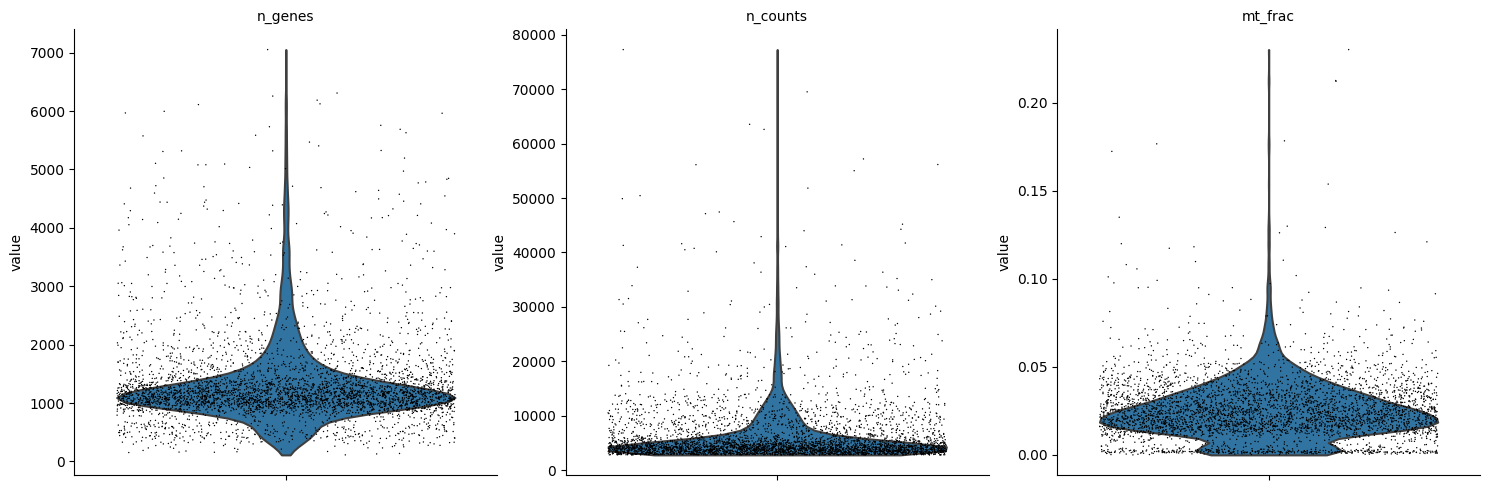

In [14]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

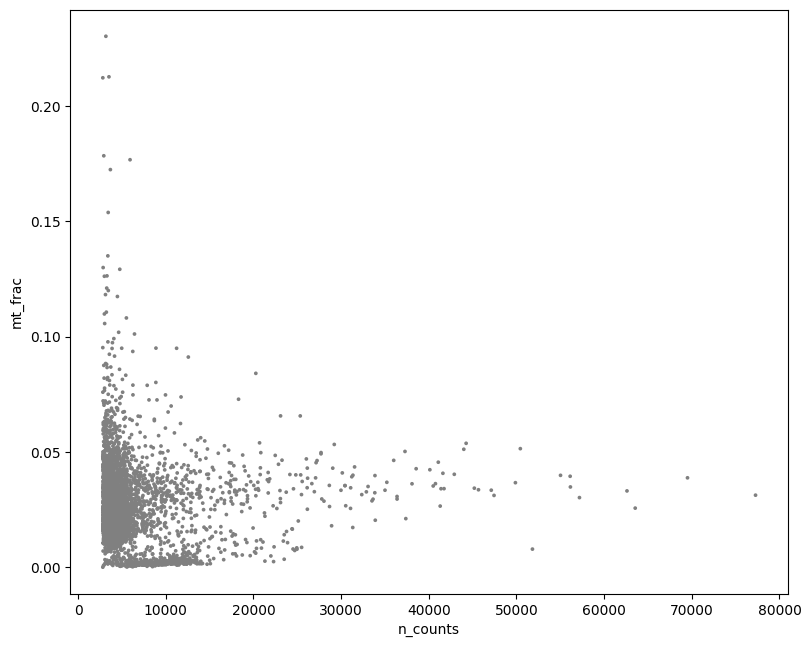

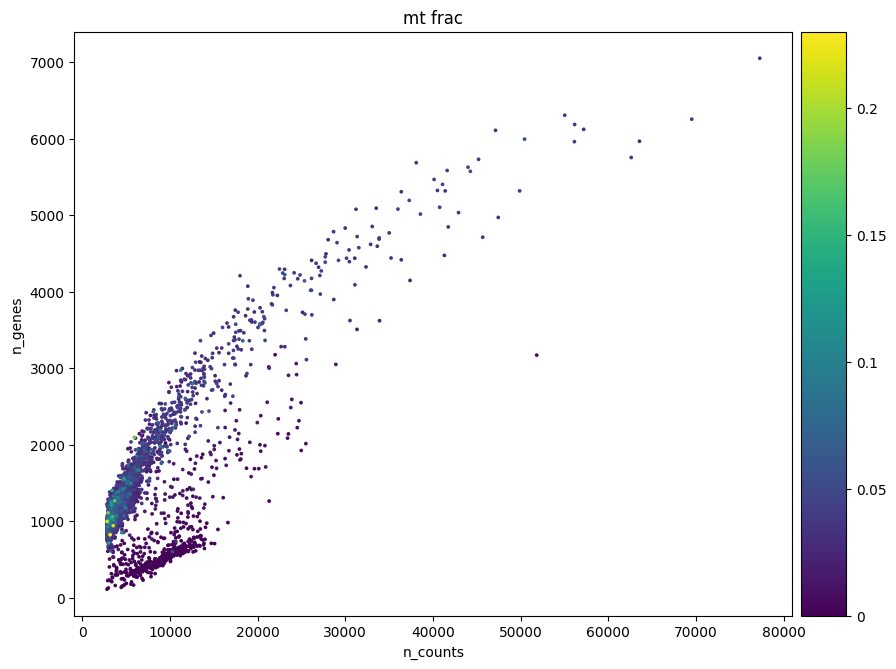

In [15]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

/home/xujing/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


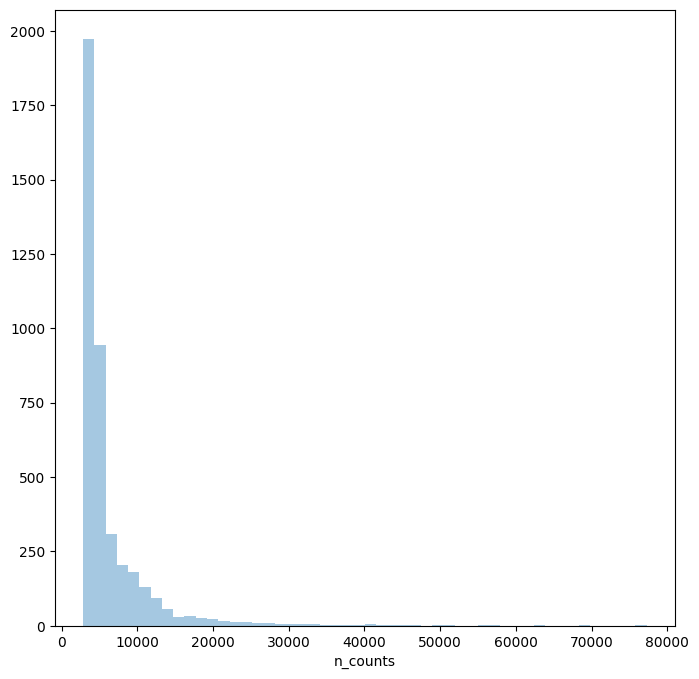

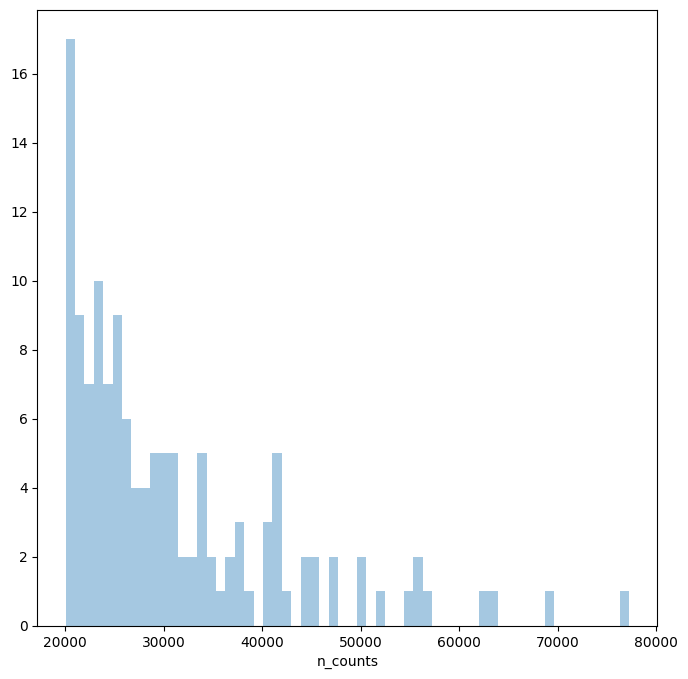

In [16]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

In [17]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 60000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 4118
filtered out 4 cells that have more than 60000 counts
Number of cells after max count filter: 4114
Number of cells after MT filter: 4111


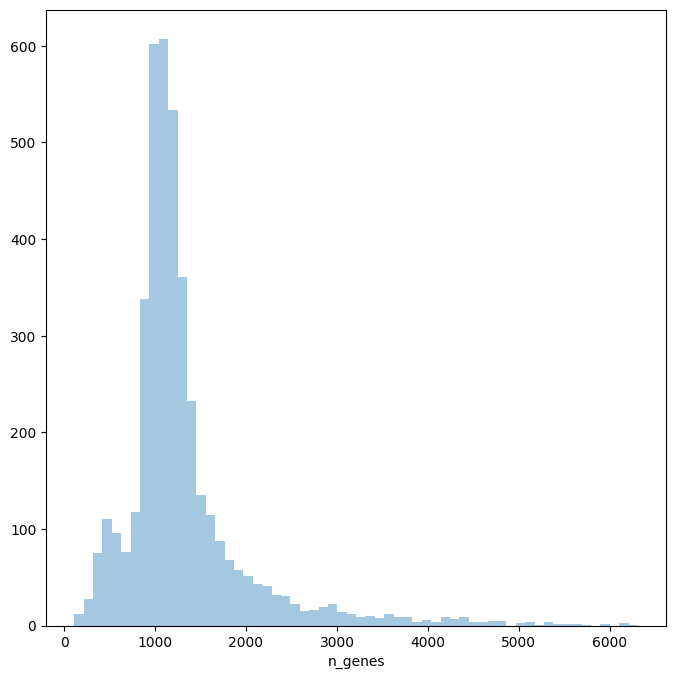

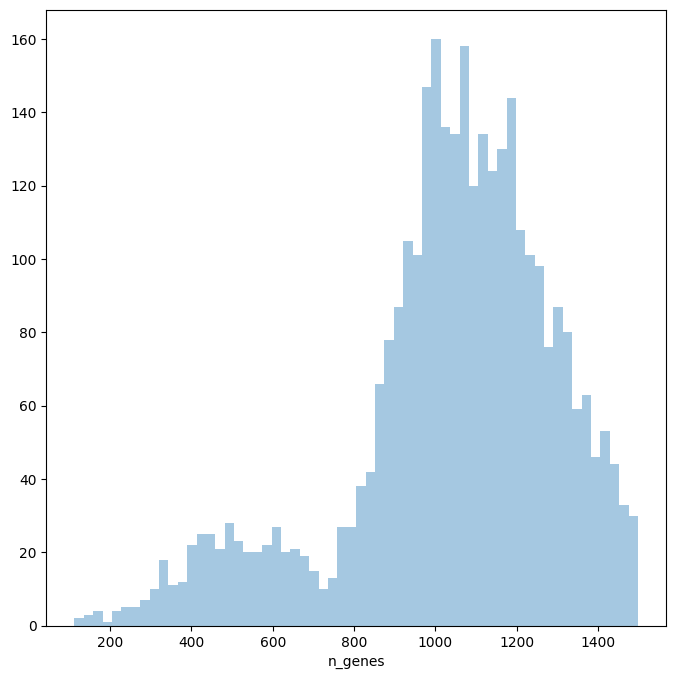

In [18]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()


From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 700 which should be filtered out.

In [19]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4111
filtered out 381 cells that have less than 700 genes expressed


/home/xujing/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of cells after gene filter: 3730


In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
# sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
Number of genes after cell filter: 33694


## 1.2 Normalization

In [21]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
result_path = "./write/"
adata.to_df().to_csv(result_path + "BM_Oetjen_3.csv")
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15


2022-11-24 09:34:42.123025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 09:34:42.276703: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-24 09:34:42.974076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7/root/usr/lib:/opt/rh/devtoolset-7/root/usr/lib64/dyninst:/opt/rh/devtoolset-7/root/usr/lib/dyninst:/opt/rh/devtoolset-7/root/usr/lib64:/opt/rh/devtoolset-7

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [72]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0    875
1    777
2    481
3    477
4    415
5    327
6    223
7     80
8     38
9     37
Name: groups, dtype: int64

In [73]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [74]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [75]:
#Delete adata_pp
del adata_pp

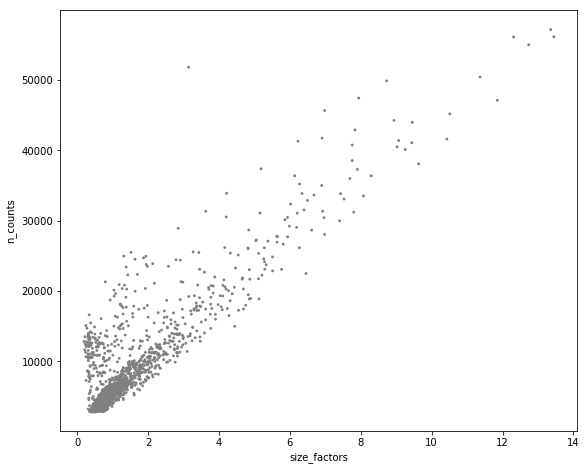

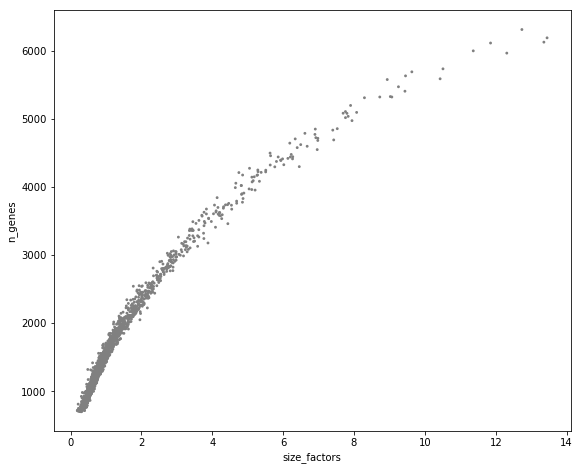

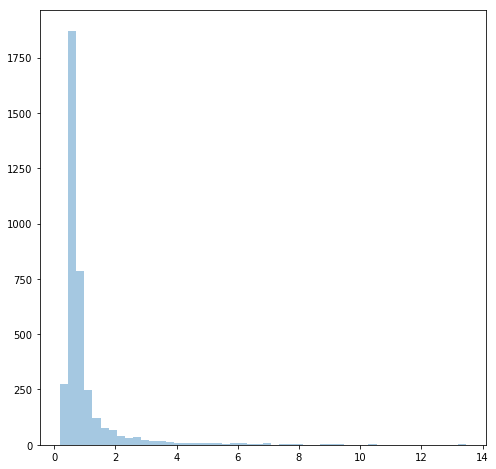

In [76]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [77]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [78]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [79]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [80]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


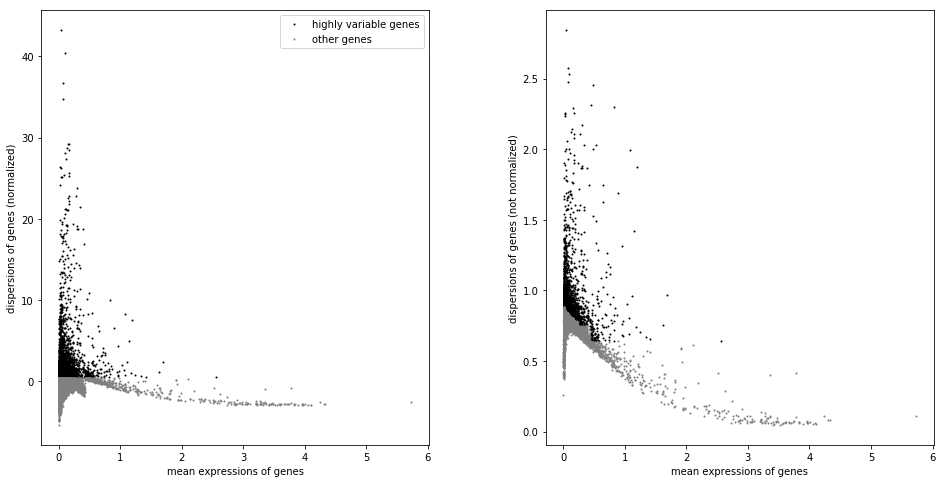

In [81]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [82]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99824125 0.9972605  0.9955709  0.9933272  0.9882703
     0.987507   0.98625904 0.98401356 0.98329896 0.98178005 0.977229
     0.9704705  0.9638524  0.96203256]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:41)


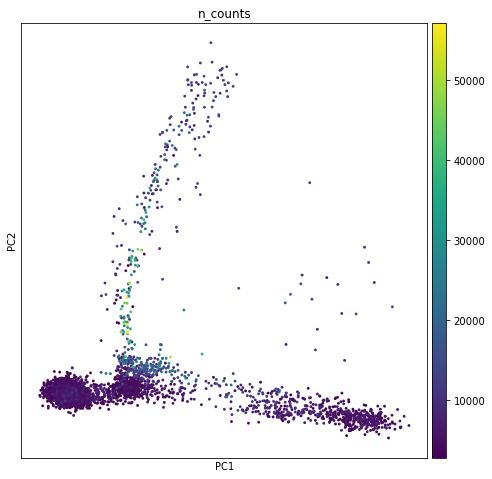

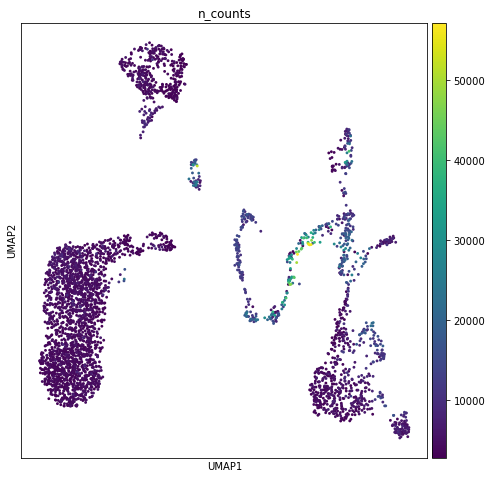

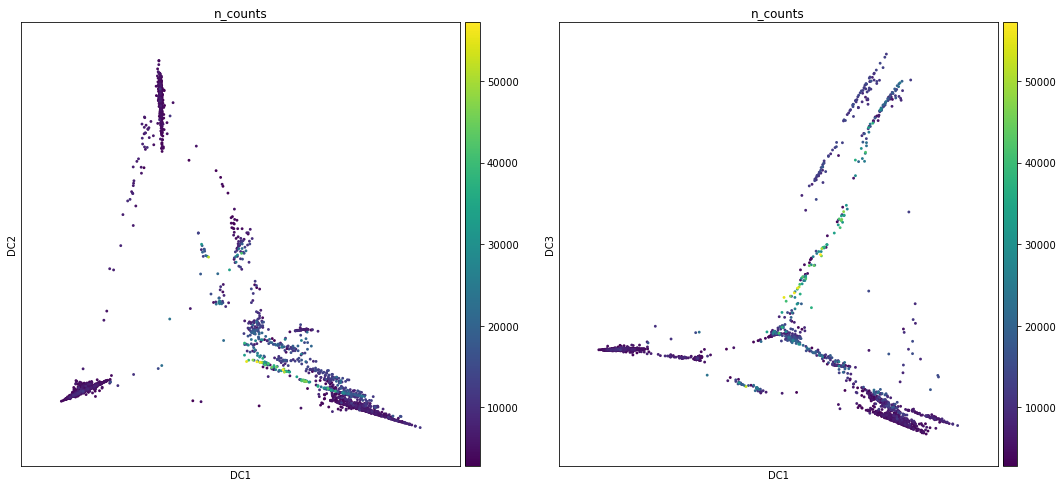

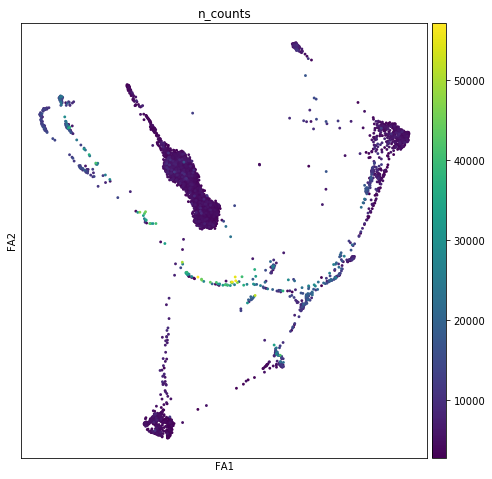

In [83]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [84]:
adata.write(results_file)

# 3. Clustering

In [85]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


In [86]:
adata.obs['louvain_r1'].value_counts()

0     1083
1      822
2      417
3      384
4      220
5      207
6      169
7      102
8       97
9       78
10      75
12      38
11      38
Name: louvain_r1, dtype: int64

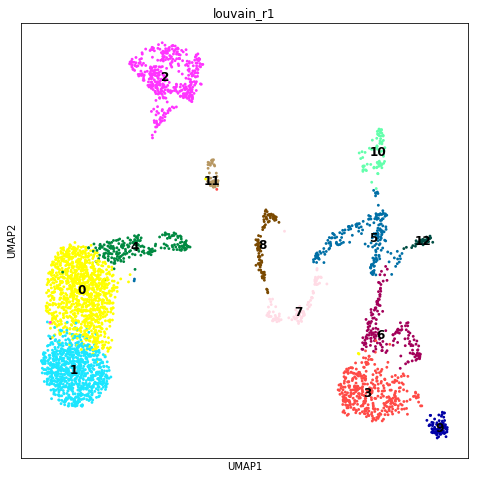

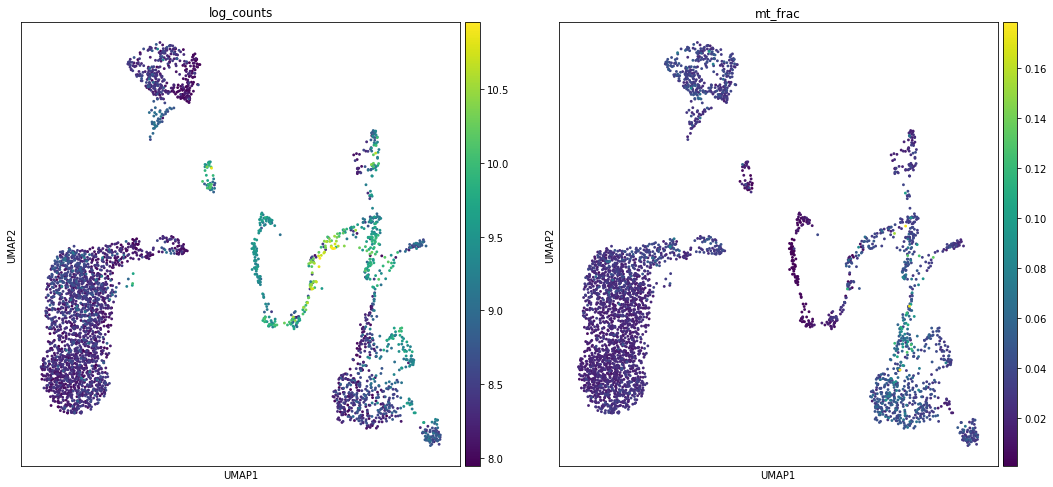

In [87]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 1)

In [88]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [89]:
markers_df = pd.read_csv('../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [90]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [91]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [92]:
# Select only human markers
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [93]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [94]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [95]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

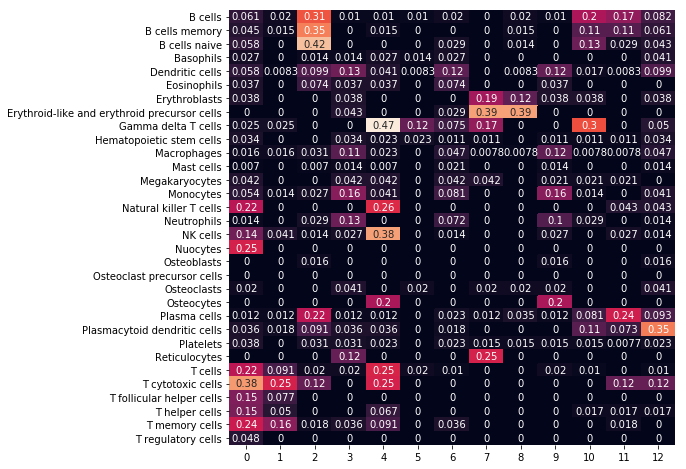

In [96]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

# 5. Plot makers of subtypes

In [97]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

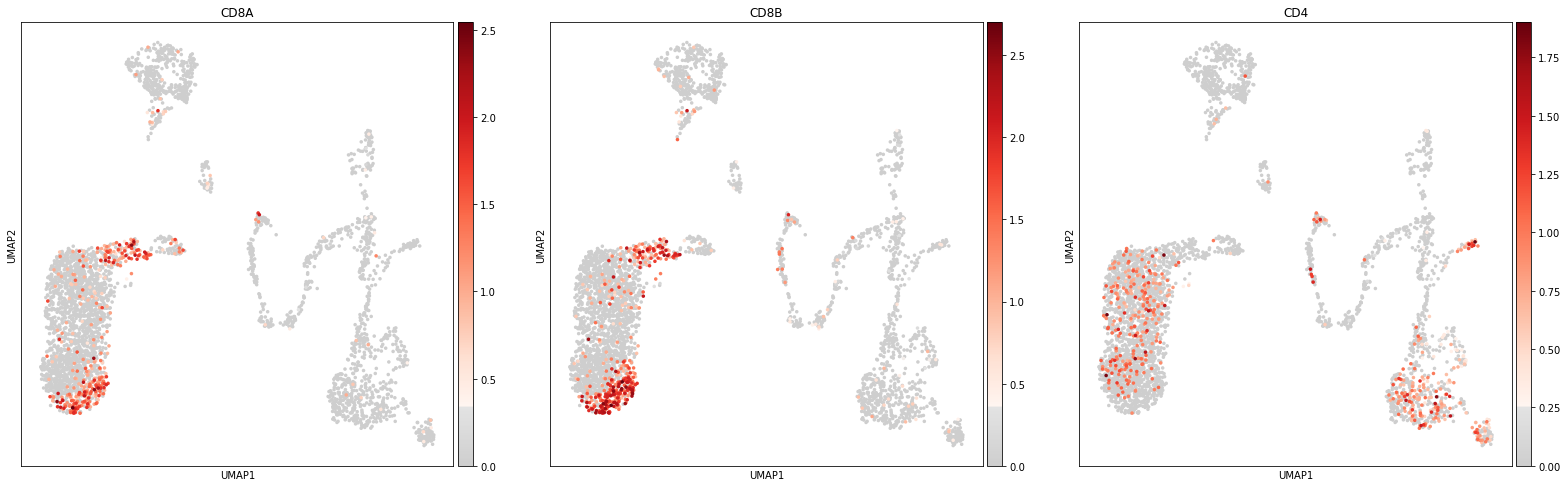

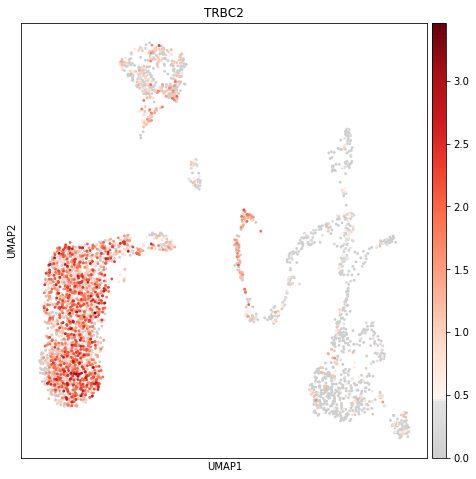

In [98]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size= 50)

# Markers from MCA
sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap)

Need to subcluster cluster 1 to annotate CD8+ T cells.

## NK cells

We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

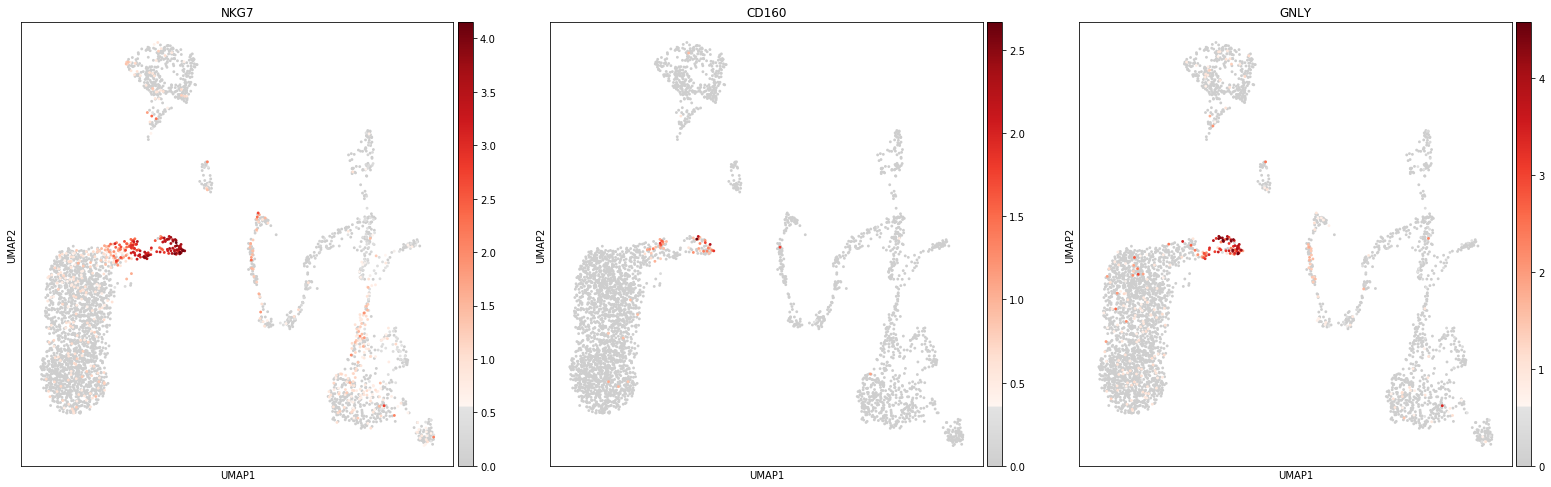

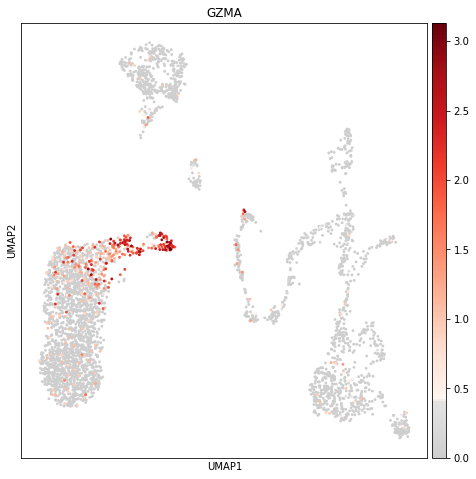

In [99]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

Need to subcluster cluster 4 to annotate NKT or NK cells.

## Monocytes: CD14+ and CD16+

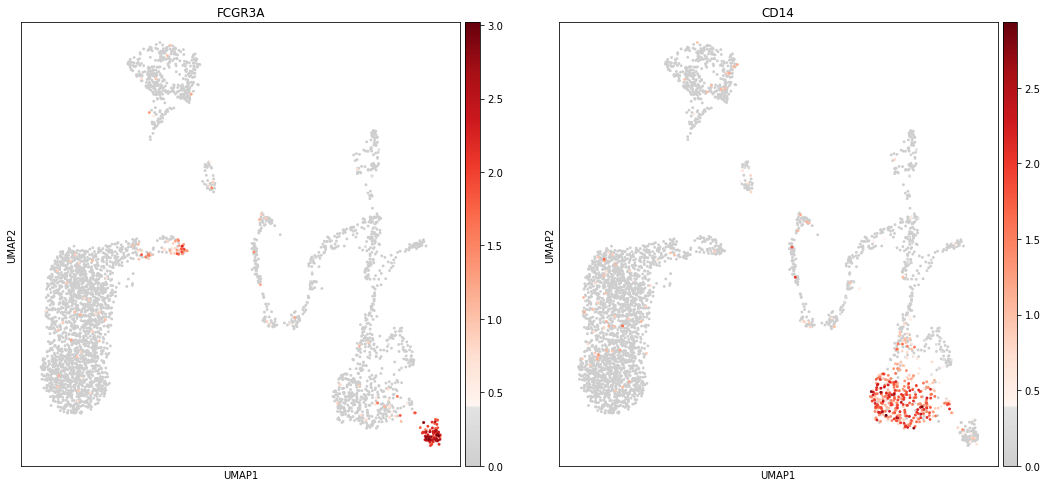

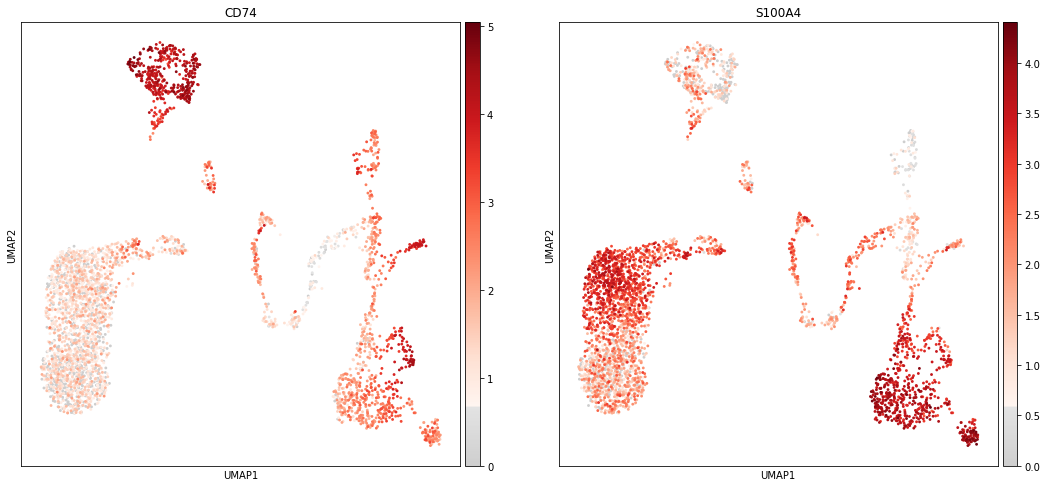

In [100]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['CD74', 'S100A4'], use_raw=False, color_map=mymap)

Cluster 9 is CD16+, cluster 3 is CD14+. 

## Monocytes progenitors

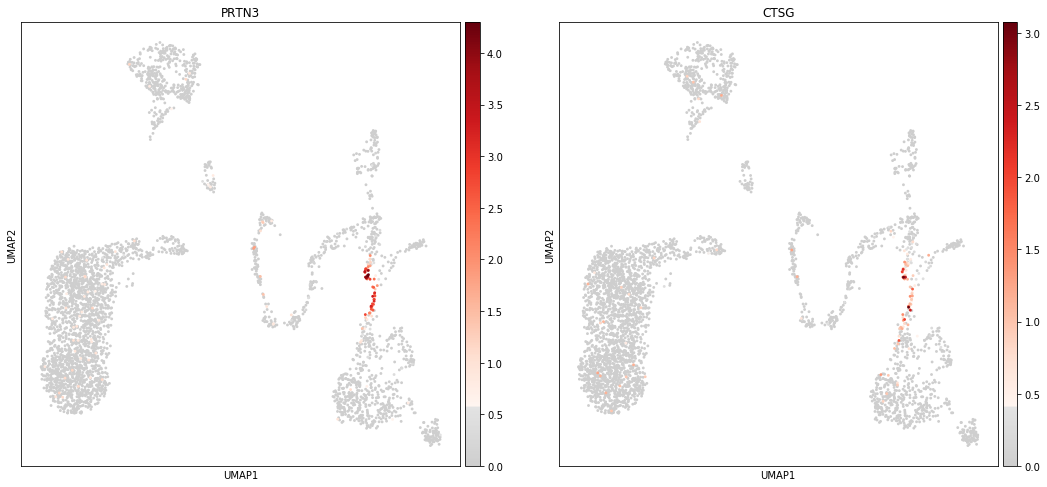

In [101]:
# Markers from MCA
sc.pl.umap(adata, color=['PRTN3','CTSG'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

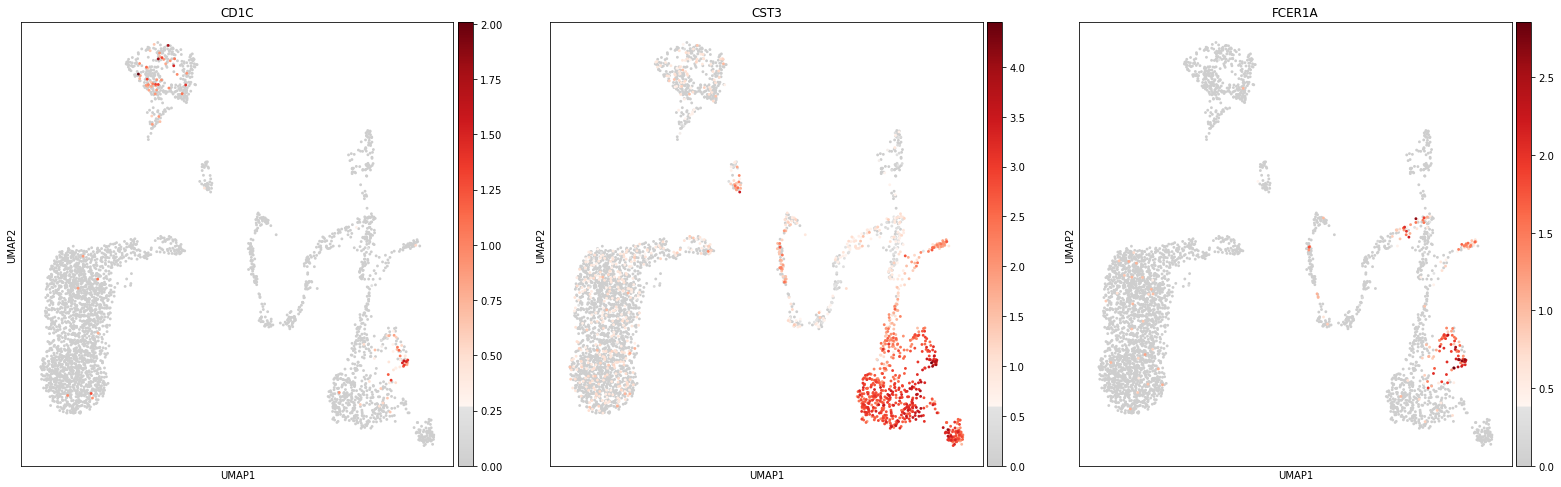

In [102]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

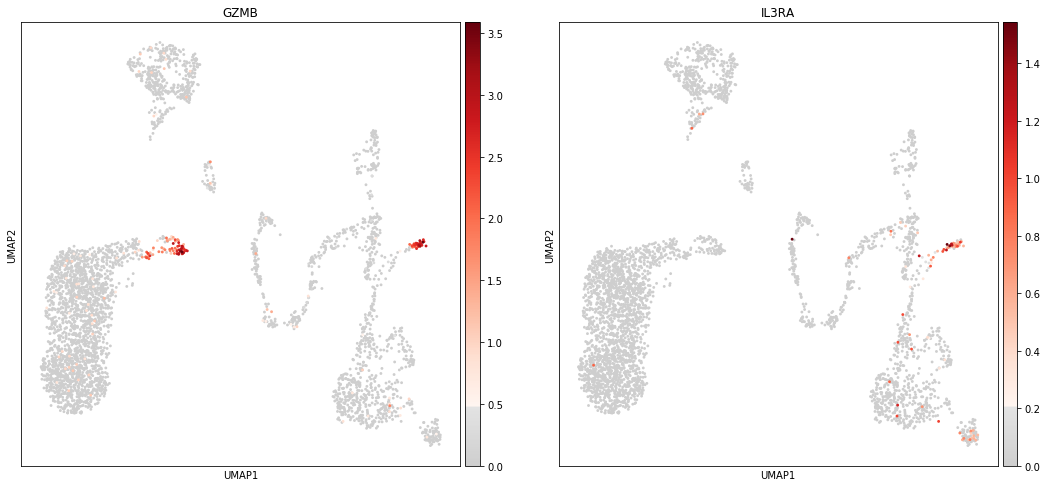

In [103]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

## B cells

Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).


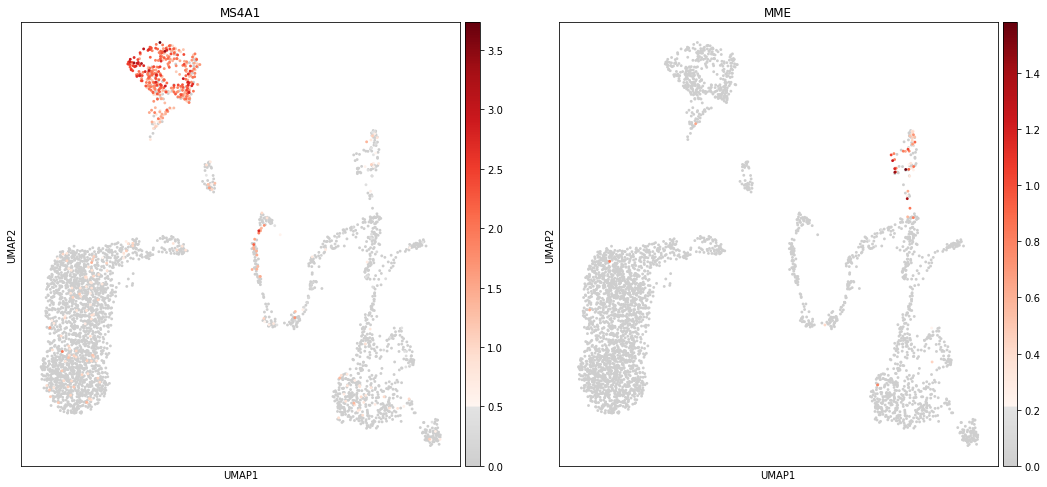

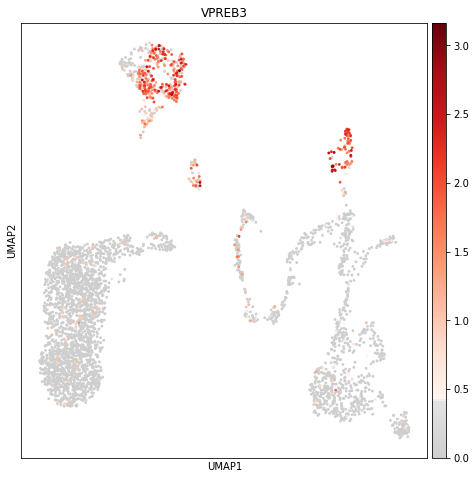

In [104]:
# Oetjen
sc.pl.umap(adata, color=['MS4A1', 'MME'], use_raw=False, color_map=mymap)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3'], use_raw=False, color_map=mymap)

## Hematopoietic stem progenitors cells (HSPCs)

Using markers from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?quickSearchInfo=bone%20marrow)

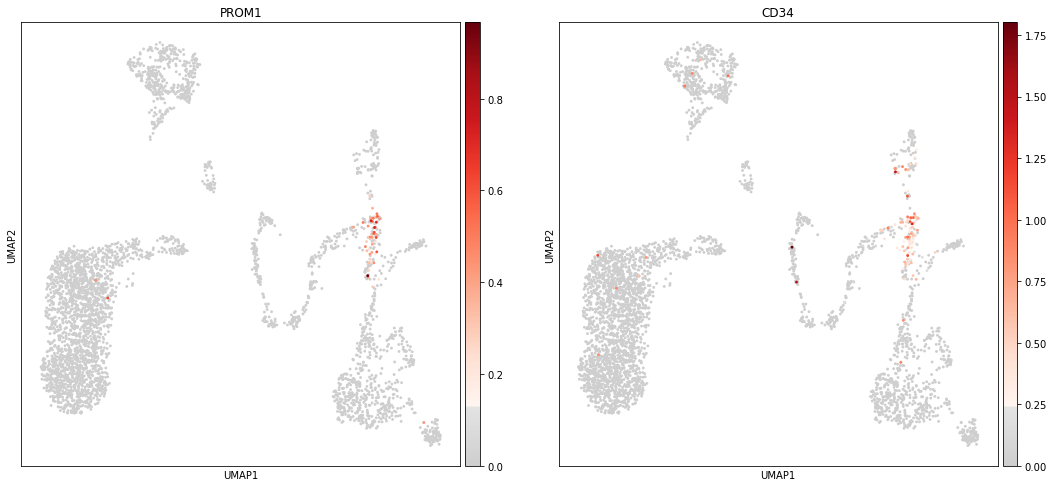

In [105]:
sc.pl.umap(adata, color=['PROM1', 'CD34'], use_raw=False, color_map=mymap)

## Megakaryocyte progenitors

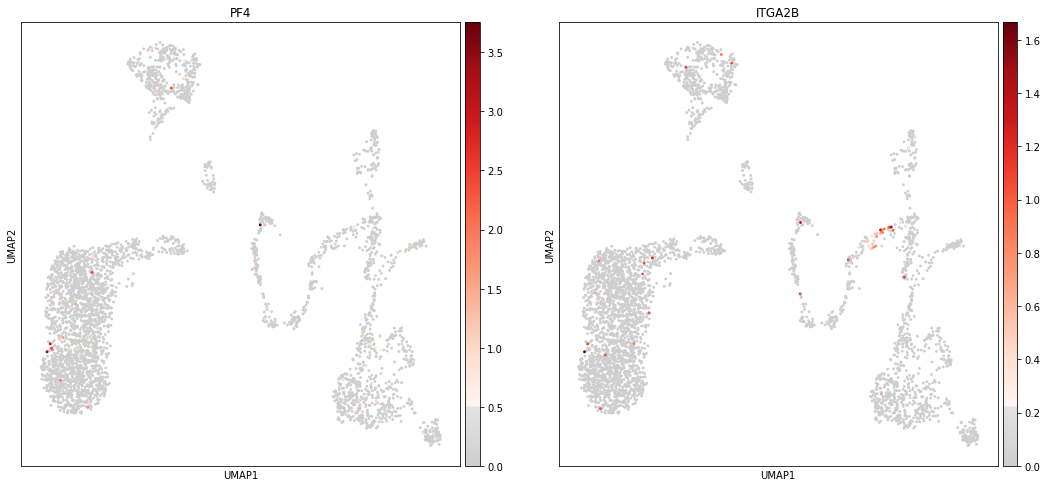

In [106]:
# Markers from Dahlin
sc.pl.umap(adata, color=['PF4', 'ITGA2B'], use_raw=False, color_map=mymap)

## Erythrocytes

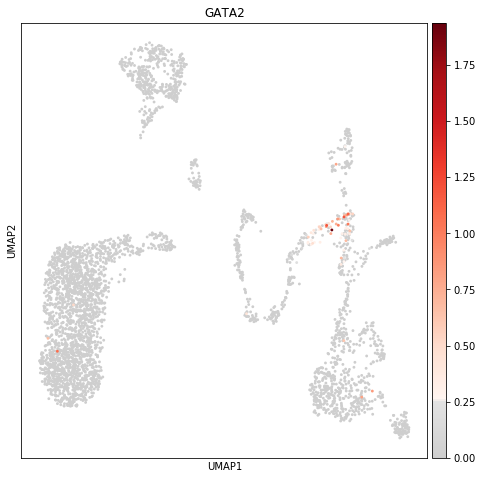

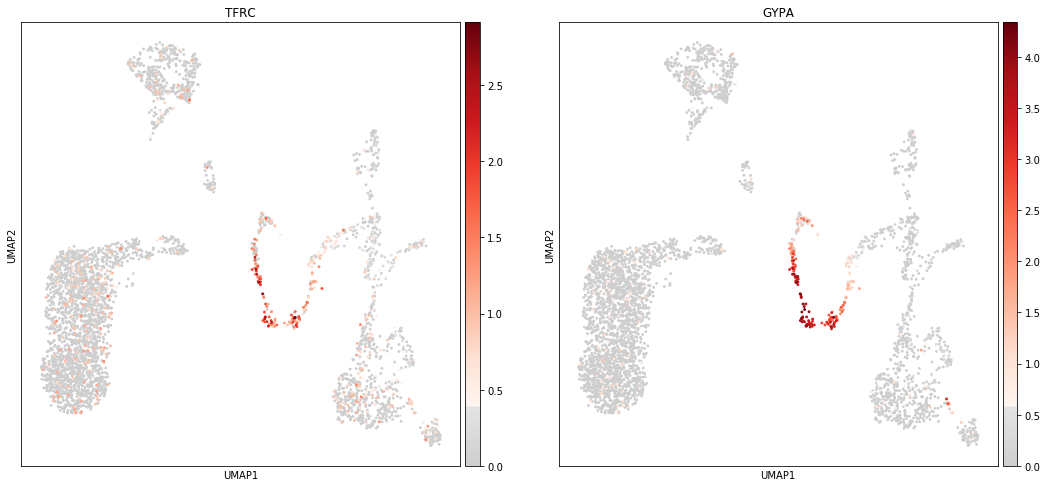

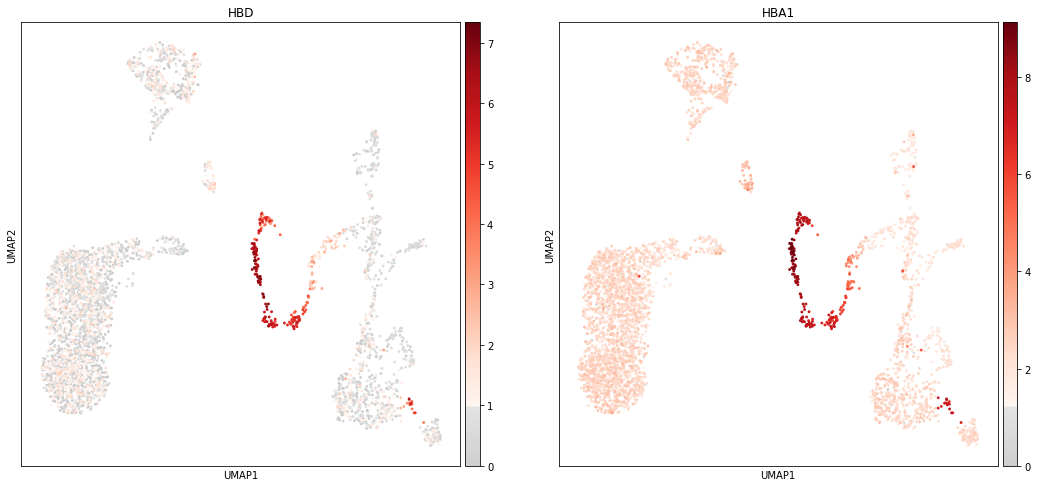

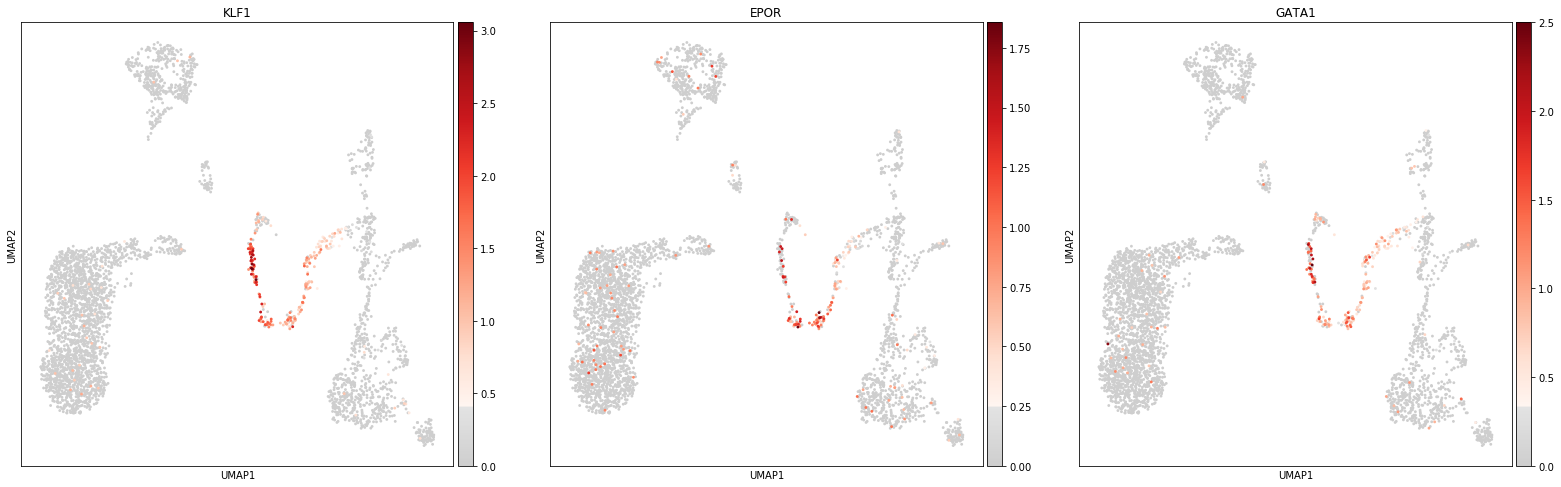

In [107]:
# Erythrocytes progenitors
sc.pl.umap(adata, color=['GATA2'], use_raw=False, color_map=mymap)

# markers from CellMarker (differentiated)
sc.pl.umap(adata, color=['TFRC', 'GYPA'], use_raw=False, color_map=mymap)

# markers from Oetjen and MCA (differentiated)
sc.pl.umap(adata, color=['HBD', 'HBA1'], use_raw=False, color_map=mymap)

# markers from Dahlin
sc.pl.umap(adata, color=['KLF1', 'EPOR', 'GATA1'], use_raw=False, color_map=mymap)

## Plasma cells

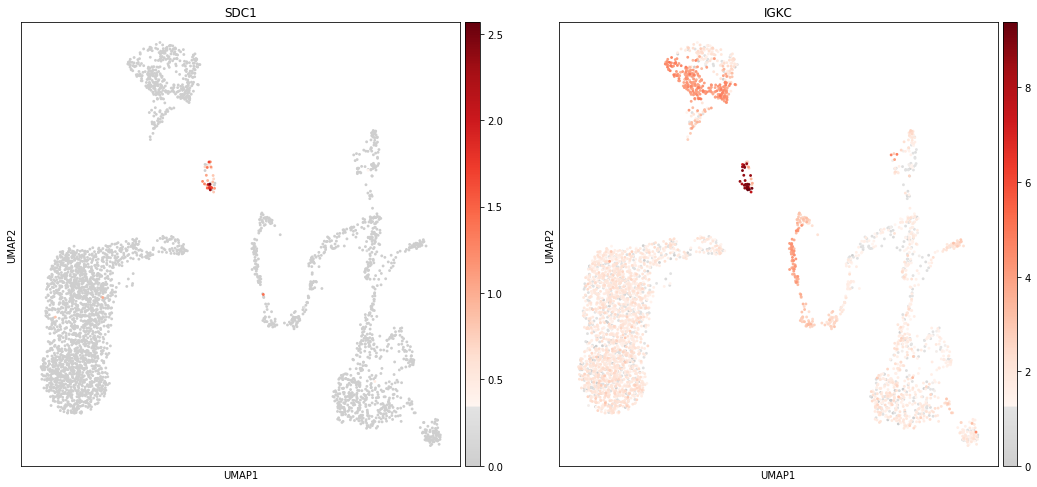

In [108]:
# From CellMarker
sc.pl.umap(adata, color=['SDC1', 'IGKC'], use_raw=False, color_map=mymap)

# 6. Subclustering

In [111]:
#Subcluster cluster1
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['1']), resolution=0.5, key_added='louvain_r1_sub1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1_sub1', the cluster labels (adata.obs, categorical) (0:00:00)


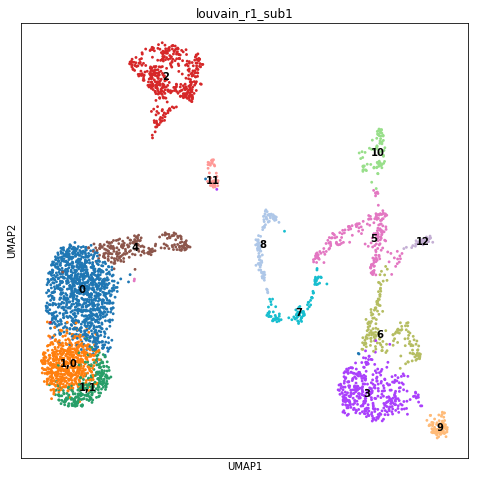

In [112]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub1', legend_loc='on data')

In [113]:
#Subcluster cluster4
sc.tl.louvain(adata, restrict_to=('louvain_r1_sub1', ['4']), resolution=0.3, key_added='louvain_r1_sub1_4')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r1_sub1_4', the cluster labels (adata.obs, categorical) (0:00:00)


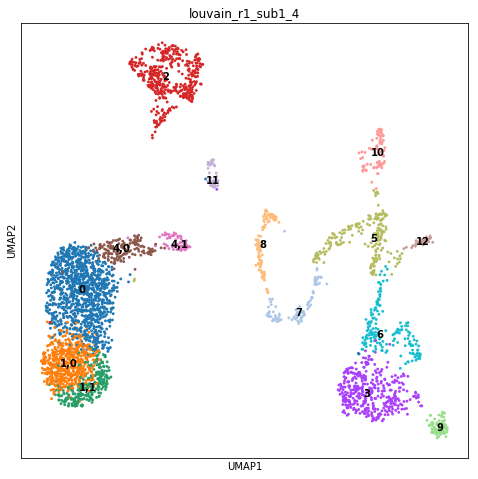

In [114]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub1_4', legend_loc='on data')

In [115]:
#Subcluster cluster6
sc.tl.louvain(adata, restrict_to=('louvain_r1_sub1_4', ['6']), resolution=0.3, key_added='louvain_r1_sub1_4_6')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_r1_sub1_4_6', the cluster labels (adata.obs, categorical) (0:00:00)


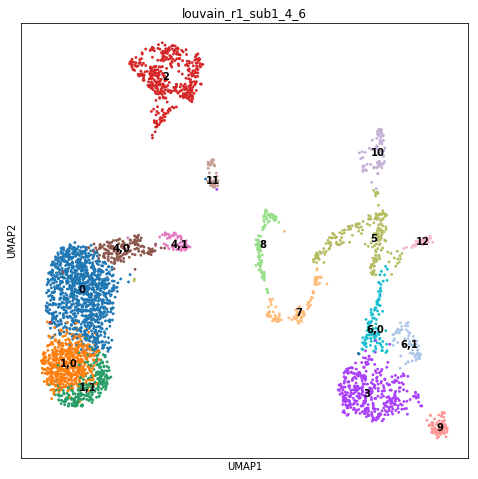

In [116]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub1_4_6', legend_loc='on data')

In [117]:
#Subcluster cluster5
sc.tl.louvain(adata, restrict_to=('louvain_r1_sub1_4_6', ['5']), resolution=0.3, key_added='louvain_r1_sub1_4_6_5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_r1_sub1_4_6_5', the cluster labels (adata.obs, categorical) (0:00:00)


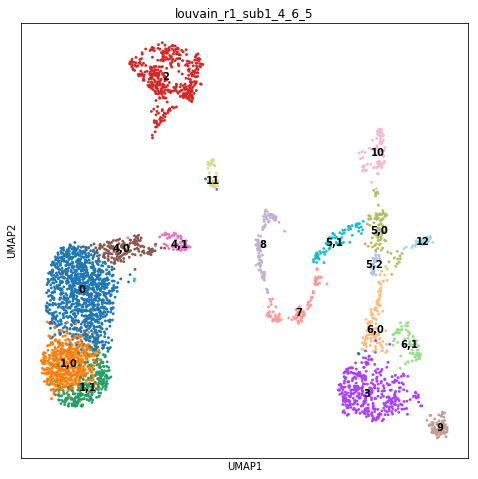

In [118]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_sub1_4_6_5', legend_loc='on data')

# 7. Final cell-type annotation

In [124]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1_sub1_4_6_5']
adata.rename_categories('final_annotation', ['CD4+ T cells,1','CD4+ T cells,2','CD8+ T cells', 'CD20+ B cells', 'CD14+ Monocytes', 'NKT cells', 'NK cells', 'HSPCs', 'Megakaryocyte progenitors', 'Monocyte progenitors,1','Monocyte progenitors,2', 'Monocyte-derived dendritic cells', 'Erythroid progenitors', 'Erythrocytes', 'CD16+ Monocytes', 'CD10+ B cells', 'Plasma cells', 'Plasmacytoid dendritic cells'])

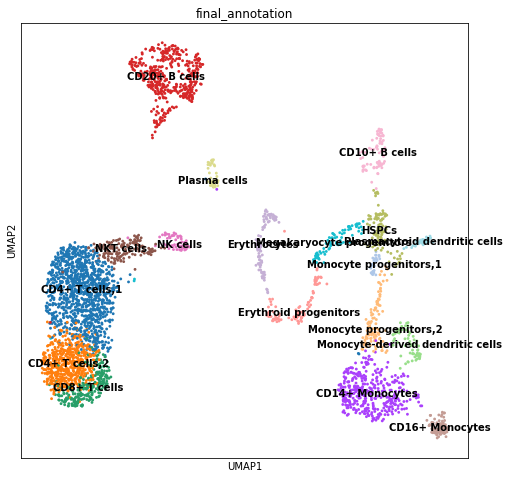

In [125]:
sc.pl.umap(adata, color='final_annotation', legend_loc='on data')

In [126]:
tmp = adata.obs['final_annotation']
tmp = ['CD4+ T cells' if item.startswith('CD4+') else item for item in tmp]
tmp = ['Monocyte progenitors' if item.startswith('Monocyte progenitors') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


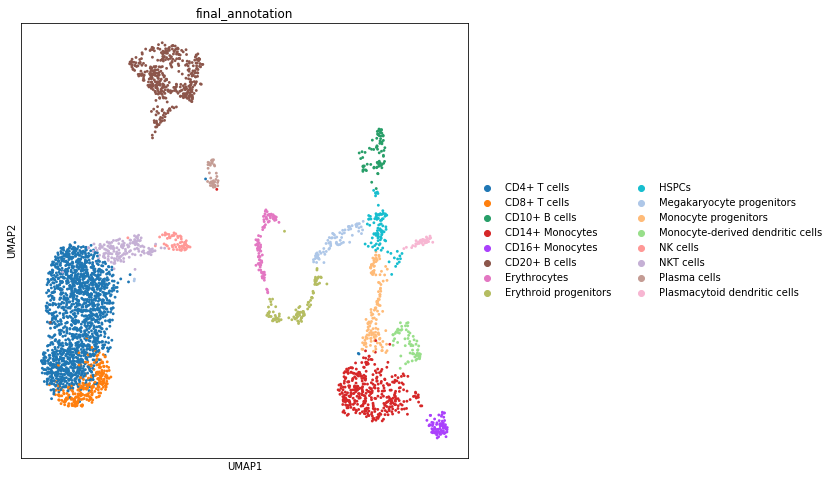

In [127]:
sc.pl.umap(adata, color='final_annotation')

In [128]:
# save final result
adata.write(results_file)

# Erythrocyte differentiation
Here we want to investigate the trajectory of erythrocytes differentiation using PAGA and DPT.

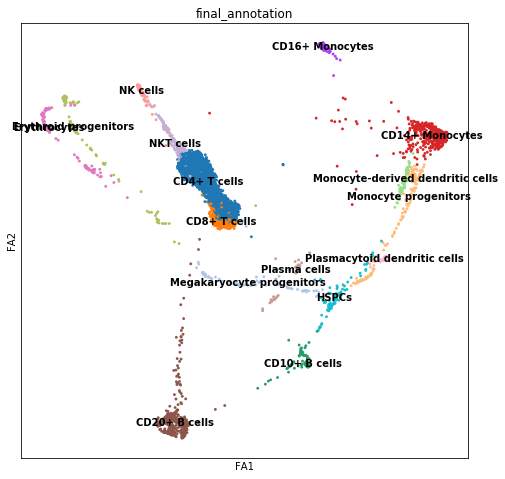

In [129]:
sc.pl.draw_graph(adata, color='final_annotation', legend_loc='on data')

In [130]:
sc.tl.paga(adata, groups='final_annotation')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


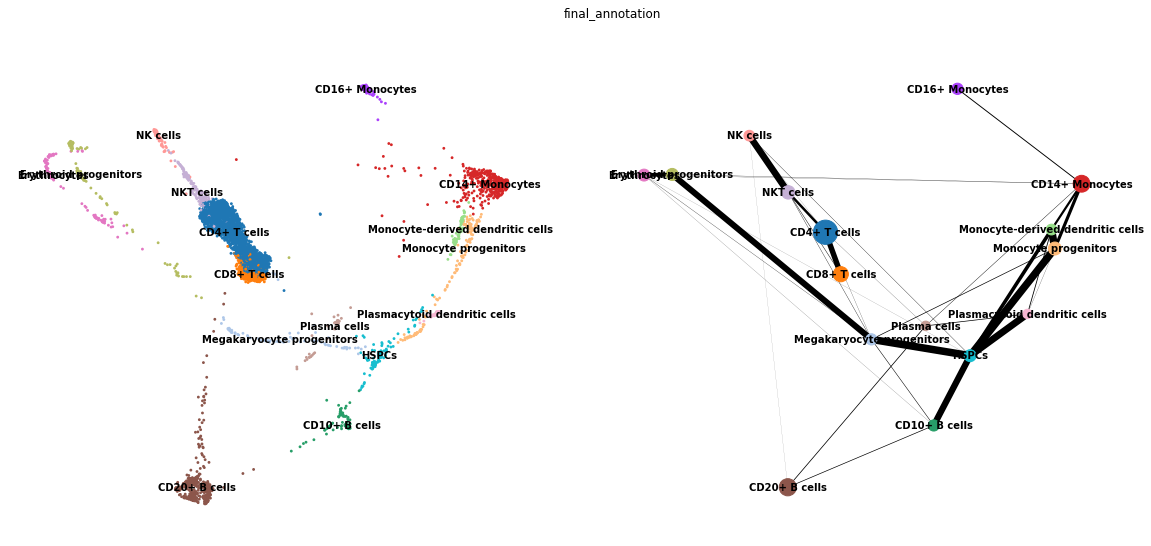

In [131]:
sc.pl.paga_compare(adata, color='final_annotation')

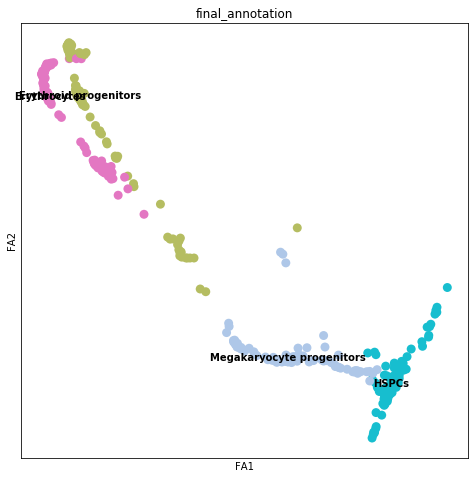

In [6]:
# Subsetting adata to only the clusters included in the trajectory
adata_ery = adata[adata.obs['final_annotation'].isin(['HSPCs', 'Megakaryocyte progenitors', 'Erythroid progenitors', 'Erythrocytes'])]
sc.pl.draw_graph(adata_ery, color='final_annotation', legend_loc='on data')

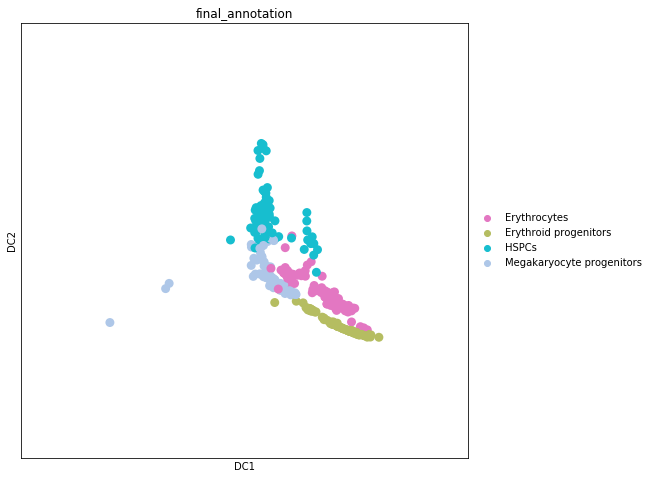

In [7]:
sc.pl.diffmap(adata_ery, components='1,2', color='final_annotation')

In DPT we must assign a root cell to infer pseudotime. We do so by looking at the diffmap plots and choosing the root cell as the one with the maximum DC2 value.


In [8]:
# Calculate pseudotime with DPT
root_mask = adata_ery.obs.final_annotation.isin(['HSPCs'])
max_root_id = np.argmax(adata_ery.obsm['X_diffmap'][root_mask,2])
root_id = np.arange(len(root_mask))[root_mask][max_root_id]
adata_ery.uns['iroot'] = root_id

sc.tl.dpt(adata_ery, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


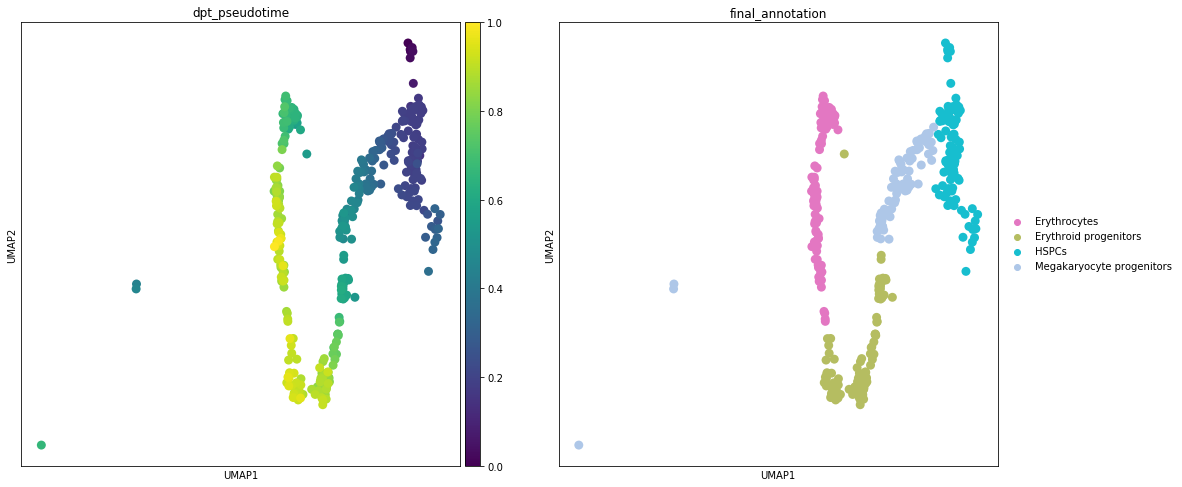

In [9]:
sc.pl.umap(adata_ery, color=['dpt_pseudotime', 'final_annotation'])

In [10]:
# Save ordering of cells in the original adata object

# save adata_ery.obs as a dataframe and make barcodes column accessible
adata_ery_df = adata_ery.obs.reset_index()
adata_ery_df.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAATGCCTCTAACTGG-1    4087.0    8.315566     1308  0.099095      0.696581   
1  AACACGTGTCGAATCT-1   13174.0    9.486000      868  0.004630      0.363620   
2  AACTCCCAGGATGGAA-1   32361.0   10.384709     4325  0.031458      6.018591   
3  AACTTTCCATAGACTC-1   14378.0    9.573455     1512  0.011545      0.825790   
4  AAGACCTGTTCCGGCA-1   36384.0   10.501884     5308  0.030645      8.294334   

  louvain_r1 louvain_r1_sub1 louvain_r1_sub1_4 louvain_r1_sub1_4_6  \
0          5               5                 5                   5   
1          8               8                 8                   8   
2          7               7                 7                   7   
3          8               8                 8                   8   
4          5               5                 5                   5   

  louvain_r1_sub1_4_6_5           final_annotation  dpt_pseudotime  
0                   5,0                      HSPCs        0.000000  
1                     8               Erythrocytes        0.990046  
2                     7      Erythroid progenitors        0.567591  
3                     8               Erythrocytes        0.650578  
4                   5,1  Megakaryocyte progenitors        0.350482

In [11]:
# prepare adata_ery_df for merging
adata_ery_df = adata_ery_df[['barcode', 'dpt_pseudotime']]
adata_ery_df.head()

barcode  dpt_pseudotime
0  AAATGCCTCTAACTGG-1        0.000000
1  AACACGTGTCGAATCT-1        0.990046
2  AACTCCCAGGATGGAA-1        0.567591
3  AACTTTCCATAGACTC-1        0.650578
4  AAGACCTGTTCCGGCA-1        0.350482

In [12]:
# save adata.obs as a dataframe and make barcodes column accessible
adata_df = adata.obs.reset_index()
adata_df.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAACCTGCACCACCAG-1    3017.0    8.012018      839  0.015247      0.439758   
1  AAACCTGGTAGGACAC-1    4297.0    8.365672     1004  0.032115      0.567141   
2  AAACCTGGTTAAGTAG-1    3537.0    8.171034      947  0.024597      0.514820   
3  AAACCTGGTTGCTCCT-1   12926.0    9.466996     2542  0.021198      1.771756   
4  AAACCTGTCGCAGGCT-1    3696.0    8.215007     1054  0.013528      0.601501   

  louvain_r1 louvain_r1_sub1 louvain_r1_sub1_4 louvain_r1_sub1_4_6  \
0          1             1,0               1,0                 1,0   
1          1             1,1               1,1                 1,1   
2          1             1,0               1,0                 1,0   
3         11              11                11                  11   
4          1             1,0               1,0                 1,0   

  louvain_r1_sub1_4_6_5 final_annotation  dpt_pseudotime  
0                   1,0     CD4+ T cells             NaN  
1                   1,1     CD8+ T cells             NaN  
2                   1,0     CD4+ T cells             NaN  
3                    11     Plasma cells             NaN  
4                   1,0     CD4+ T cells             NaN

In [13]:
# merge the two dataframes
adata_merge = adata_df.merge(adata_ery_df, how='left', on='barcode')
adata_merge.head()

barcode  n_counts  log_counts  n_genes   mt_frac  size_factors  \
0  AAACCTGCACCACCAG-1    3017.0    8.012018      839  0.015247      0.439758   
1  AAACCTGGTAGGACAC-1    4297.0    8.365672     1004  0.032115      0.567141   
2  AAACCTGGTTAAGTAG-1    3537.0    8.171034      947  0.024597      0.514820   
3  AAACCTGGTTGCTCCT-1   12926.0    9.466996     2542  0.021198      1.771756   
4  AAACCTGTCGCAGGCT-1    3696.0    8.215007     1054  0.013528      0.601501   

  louvain_r1 louvain_r1_sub1 louvain_r1_sub1_4 louvain_r1_sub1_4_6  \
0          1             1,0               1,0                 1,0   
1          1             1,1               1,1                 1,1   
2          1             1,0               1,0                 1,0   
3         11              11                11                  11   
4          1             1,0               1,0                 1,0   

  louvain_r1_sub1_4_6_5 final_annotation  dpt_pseudotime_x  dpt_pseudotime_y  
0                   1,0     CD4+ T cells               NaN               NaN  
1                   1,1     CD8+ T cells               NaN               NaN  
2                   1,0     CD4+ T cells               NaN               NaN  
3                    11     Plasma cells               NaN               NaN  
4                   1,0     CD4+ T cells               NaN               NaN

In [14]:
# reassign merged dataframe as adata.obs
adata_merge.set_index('barcode', inplace = True)
adata.obs = adata_merge

In [15]:
# save final result
adata.write(results_file)